<a href="https://colab.research.google.com/github/shintafiaa/Kampus-Merdeka-Pengembangan-ML/blob/main/17_Submission_Deployment_to_Android.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import shutil
import os

In [2]:
!pip install kaggle

In [3]:
#memindahkan file jason ke dalam suatu folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#paste "Copy API command"
!kaggle datasets download -d andrewmvd/animal-faces

100% 694M/696M [00:17<00:00, 37.7MB/s]
100% 696M/696M [00:17<00:00, 42.2MB/s]


In [5]:
from zipfile import ZipFile
file_name = 'animal-faces.zip'
with ZipFile(file_name, "r") as zip:
  zip.extractall()
print('Done')

Done


In [15]:
print('Total cat images :', len(os.listdir('/content/afhq/train/cat')))
print('Total dog images :', len(os.listdir('/content/afhq/train/dog')))
print('Total wild images :', len(os.listdir('/content/afhq/train/wild')))

Total cat images : 5653
Total dog images : 5239
Total wild images : 5238


In [16]:
#import image generator dan mengaplikasikan augmentasi gambar
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join('/content/afhq/train')
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   fill_mode='nearest',
                                   validation_split=0.2) #set validation split

In [17]:
#membagi data training dan data testing menggunakan parameter subset 'training'/'validation'
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=8,
    class_mode='categorical',
    subset='training',
) #set as training data
validation_generator = train_datagen.flow_from_directory(
    train_dir, #direktori yang sama dengan data train
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
)

Found 12906 images belonging to 3 classes.
Found 3224 images belonging to 3 classes.


In [18]:
#arsitektur model 3 layer convolution dan 2 hidden layer; 512 dan 256 unit perseptron
import tensorflow as tf
model = tf.keras.models.Sequential([
    #input shape 150x150 pixel dan 3 bytes warna
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    #flatten the result to feed into a DNN
    tf.keras.layers.Flatten(),
    #512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    #output dengan 1 neuron
    tf.keras.layers.Dense(3, activation='softmax')
])

In [19]:
#optimizer dan loss
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.8 and
       logs.get('val_accuracy') > 0.8):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [22]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=50,
                              callbacks=[callbacks],
                              verbose=2)

Epoch 1/50
1614/1614 - 178s - loss: 0.6424 - accuracy: 0.7148 - val_loss: 0.3600 - val_accuracy: 0.8635
Epoch 2/50
1614/1614 - 145s - loss: 0.2704 - accuracy: 0.8983 - val_loss: 0.2416 - val_accuracy: 0.9082

Akurasi telah mencapai >90%!


In [23]:
import matplotlib.pyplot as plt

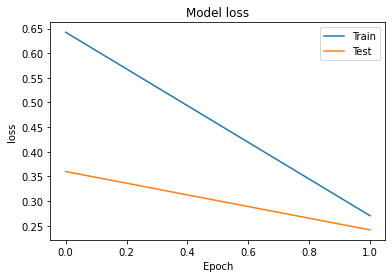

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

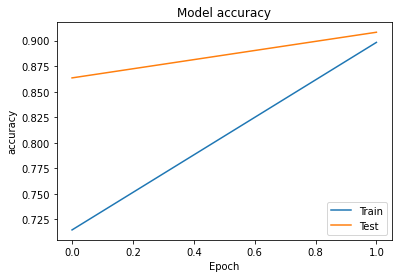

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

**SAFE MODEL TO TF LITE**

In [30]:
# Convert the TensorFlow model that already trained to be tflite using TFLiteConverter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpkkmplu86/assets


In [31]:
# Convert the TensorFlow model that already trained to be tflite using TFLiteConverter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp1lx3fsos/assets


INFO:tensorflow:Assets written to: /tmp/tmp1lx3fsos/assets


In [32]:
import tarfile
def tardir(path, tar_name):
    with tarfile.open(tar_name, "w:gz") as tar_handle:
        for root, dirs, files in os.walk(path):
            for file in files:
                tar_handle.add(os.path.join(root, file))
tardir('root/my_model.pb', 'my_model.tar.gz')
%cd

/root


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
